# Credit card fraud detection on remote locations

The chosen topic is the prevention of fraud in the use of credit cards in remote locations. The application of data science in this proposal is a topic that attracts me and is very important for financial institutions. How to improve current models and mitigate new frauds is a topic that I would like to learn and apply

### Case
1. A bank is receiving several customer complaints about transaction declines in processing credit card payments. The reports come from clients who are on vacation or business trips. Transaction declines occur because current fraud detection algorithms report a high-risk score when the customer is outside the predictive payment pattern by location. The bank wants to reduce customer complaints.
2. Can we improve the current fraud detection model to reduce customer complaints?

Assuming the bank has access to information related to accounts, transactions, and customer IDs. The bank uses its fraud detection model, it does not use a third-party service for fraud detection.

### Analytic Approach: 
Predictive analysis. The hypothesis is that we can eliminate some false positive alerts by finding a logical path of locations in previous transactions of the same customer. This theory will only apply if there are records of the customer's previous transactions.

Two example cases for this approach.
1. If previous records indicate that the customer went to one airport and then processed a transaction in a different state in the same country using the same credit card, this could be a logical path. The risk score could be lowered if the predictor The model confirms a low risk.
2. If previous records indicate that the customer put gas in the car and bought food in a city between their home city and the destination city where the problem occurs, this could be a logical path and the risk score could be lowered if the predictor model confirms a low risk.


### Data Requirements: 

To address these cases we must collect the following information
Transactions related with the credit card fraud alert in the last week, starting with the transaction decline in descending order by date
Transaction required fields: 
- Customer name
- Credit card number
- Fraud type
- Risk score
- Fraud confirmation status (true/false)
- Business or entity type that processes transaction (airport, other)
- Address (country, state, city, zip, coordinates latitude and longitude)
- Transaction Date and Time



### Data Collection:
Data will be collected from bank db. servers from the Cloud or On-premise server with the help of DBAs
Verify if the data collected is complete, or we need other source of information to continue.
Access to an API service name "ValidRoute" to check if the path of transaction locations by coordinates (Lat, long) follows a logical path. The API will return true or false, the parameters will be the list of previous transactions related with the customer account.

### Data understanding and Preparation

Clean the collected information, maintain customer records with their previous transactions in a predefined period, and check the data format.v
create a data set that contains (fraud_status,LocationTrack,airport,Localcountry,LocalState,LocalCity)
Verify data set with some data visualization to confirm data relation was created as expected, find Insights 
Create a data set grouping in one row all transactions per customer, LocationTrack field: will have the result of the API "ValidRoute"  



In [57]:

import pandas as pd # import library to read data into dataframe
pd.set_option("display.max_columns", None)
import numpy as np # import numpy library
import re # import library for regular expression
import random # library for random number generation

from pyodide.http import pyfetch
import pandas as pd



# initialize data of lists of credict cards transactions.
# data is created manually to simulate collection of data and  concept
data = {
        'fraud_status':   ['no_fraud', 'no_fraud', 'fraud', 'fraud','no_fraud', 'fraud','no_fraud', 'fraud','no_fraud', 'no_fraud', 'fraud', 'fraud','no_fraud', 'fraud','no_fraud', 'fraud'],
        'LocationTrack': [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        'airport':       [1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1], 
        'Localcountry':  [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
        'LocalState':    [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
        'LocalCity':     [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0]
       }
       
 
# Create DataFrame
df = pd.DataFrame(data)
names = df['fraud_status'] 
scores = df[['LocationTrack','airport','Localcountry','LocalState','LocalCity']]


In [58]:
# import decision trees scikit-learn libraries

from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import itertools

scores.head()

,LocationTrack,airport,Localcountry,LocalState,LocalCity
0,0,1,1,1,1
1,1,0,1,1,1
2,0,0,1,1,1
3,0,1,0,0,0
4,0,1,1,1,1


### Model and Evaluation
Create a decision tree to validate model and data collected

In [59]:

transaction_tree = tree.DecisionTreeClassifier(max_depth=3)
transaction_tree.fit(scores,names)

DecisionTreeClassifier(max_depth=3)

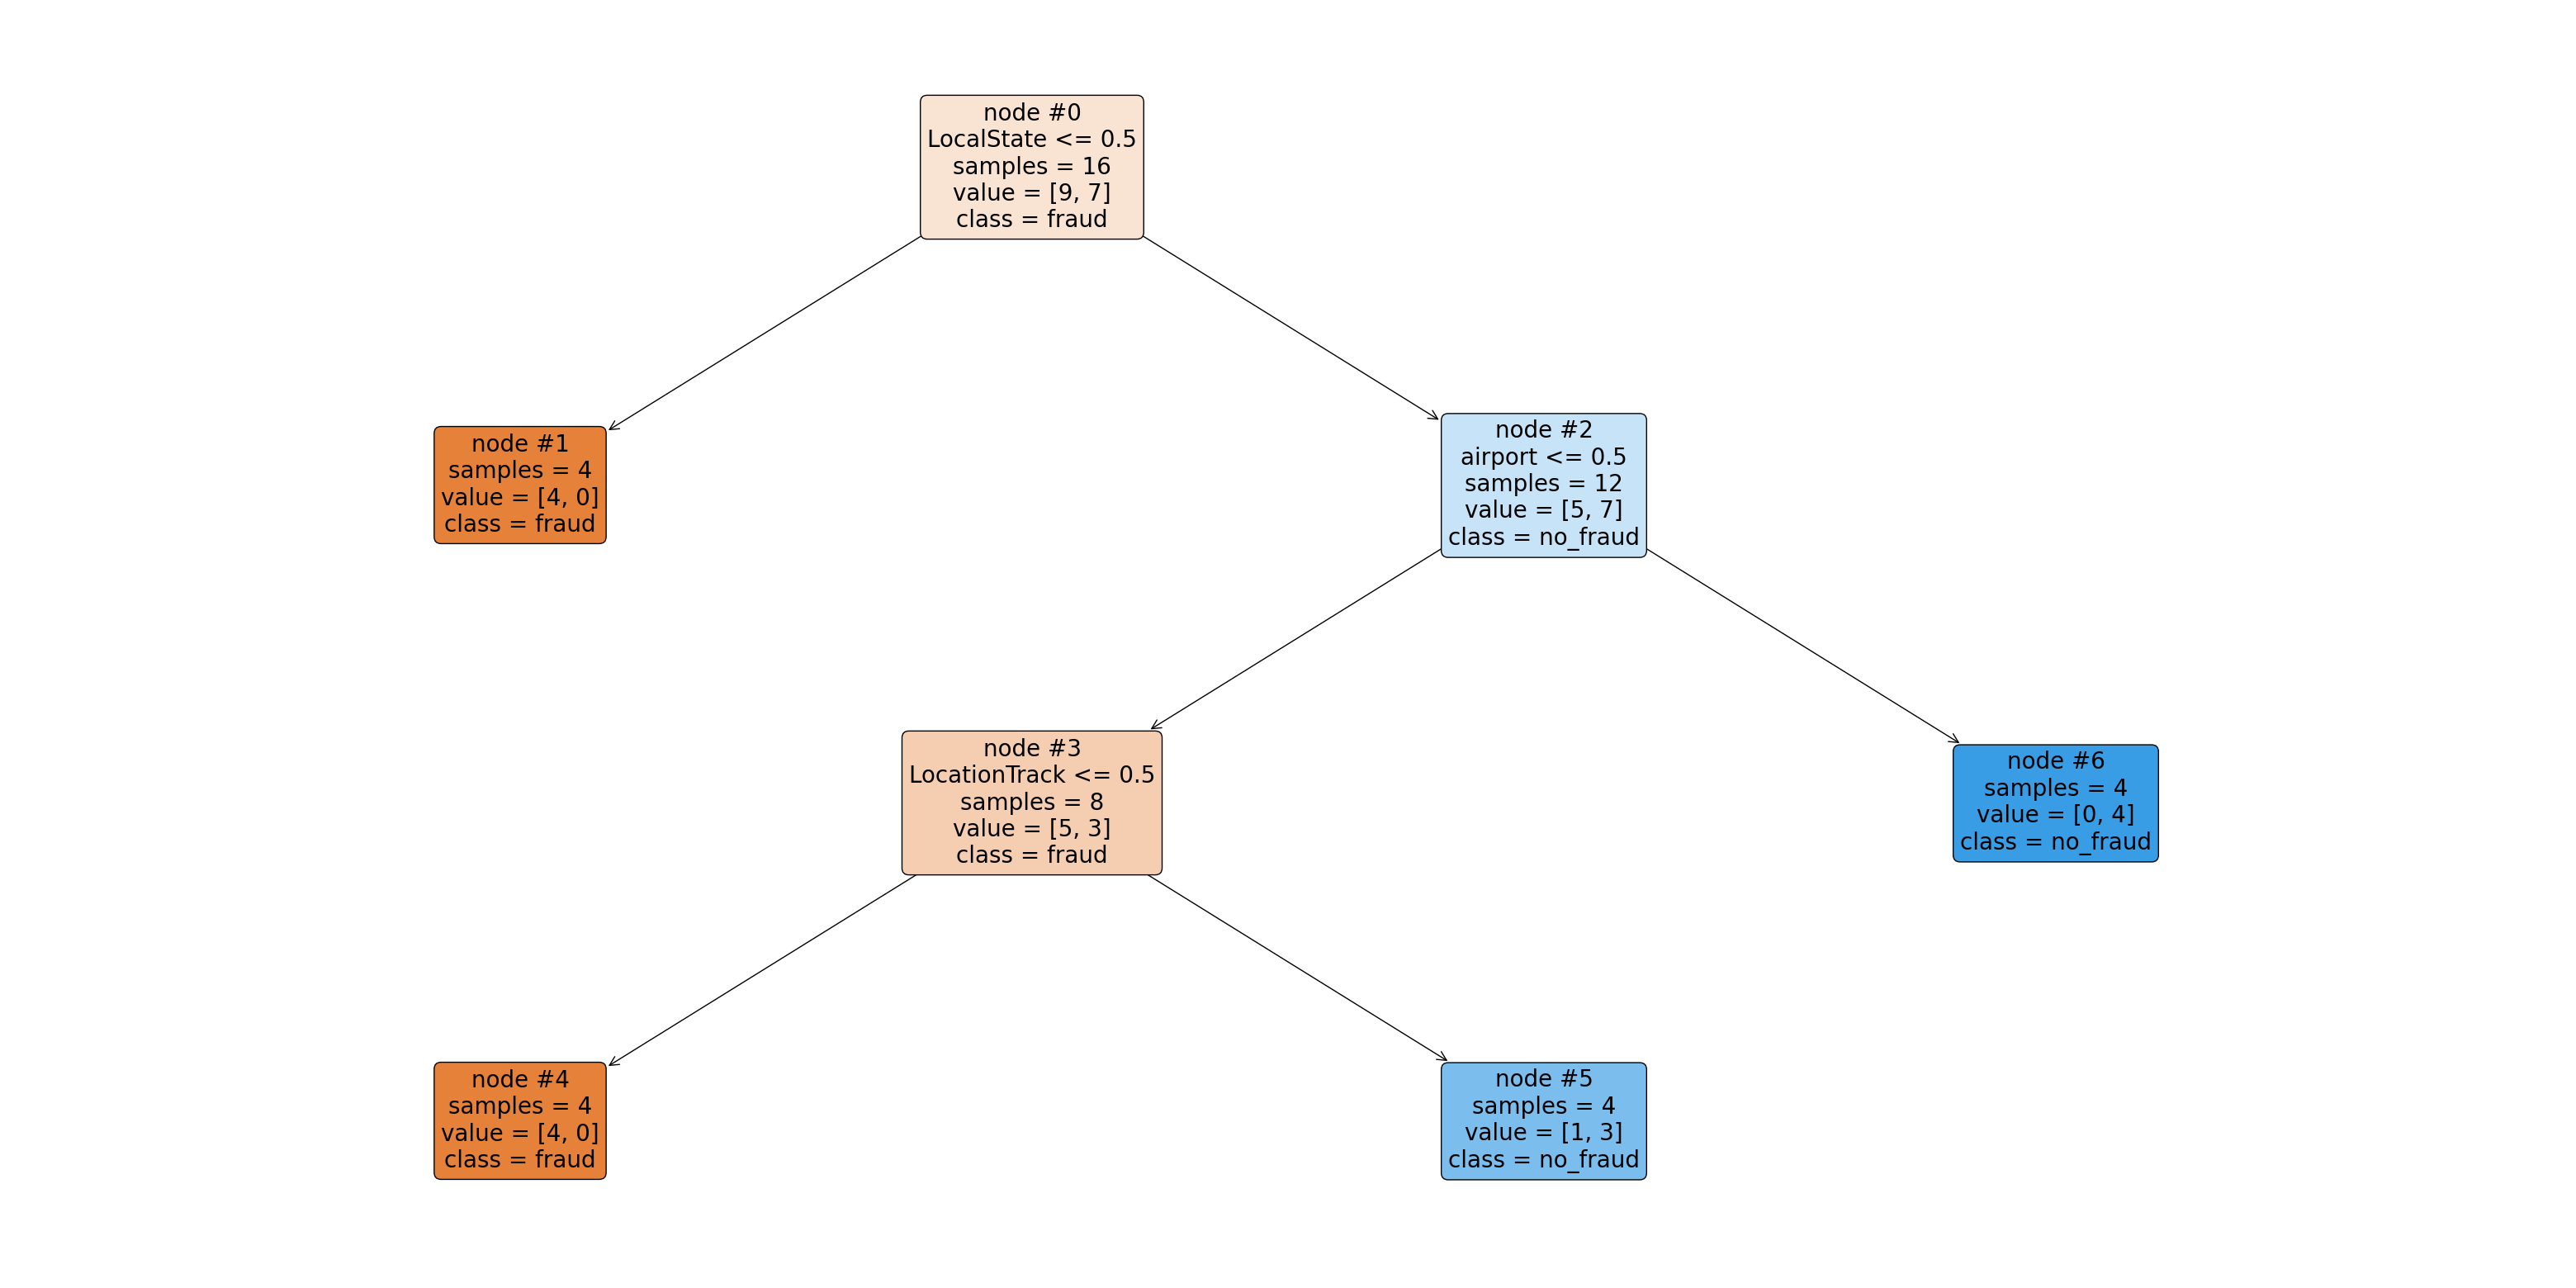

In [60]:
plt.figure(figsize=(40,20))  # customize according to the size of your tree
_ = tree.plot_tree(transaction_tree,
                   feature_names = list(scores.columns.values),
                   class_names=np.unique(names),filled=True,
                   node_ids=True,
                   impurity=False,
                   label="all",
                   fontsize=20, rounded = True)
plt.show()


### Model Result 
- If one of the transactions was executed out of the country, the model confirm a posible fraud (hight risk)
- If one of the previus transactions were executed in the same country and one transaction involve an airport the transaction, the model confirm not a fraud (low risk)
- If one of the previus transactions were executed in the same country and a track of location indicated a logic path, the model confirm not a fraud (low risk)
- If one of the previus transactions were executed in the same country and a track of location indicated invalid path, the model confirm a posible fraud (hight risk)

Lets create a predictive model and a test set of data to validate the approuch 

In [61]:
transaction_test_labels = df["fraud_status"]
transaction_test_scores = df[['LocationTrack','airport','Localcountry','LocalState','LocalCity']]
transaction_pred_fraud = transaction_tree.predict(transaction_test_scores)

In [ ]:
lets create a confusion matrix to validate model prediction, using test sets of data 

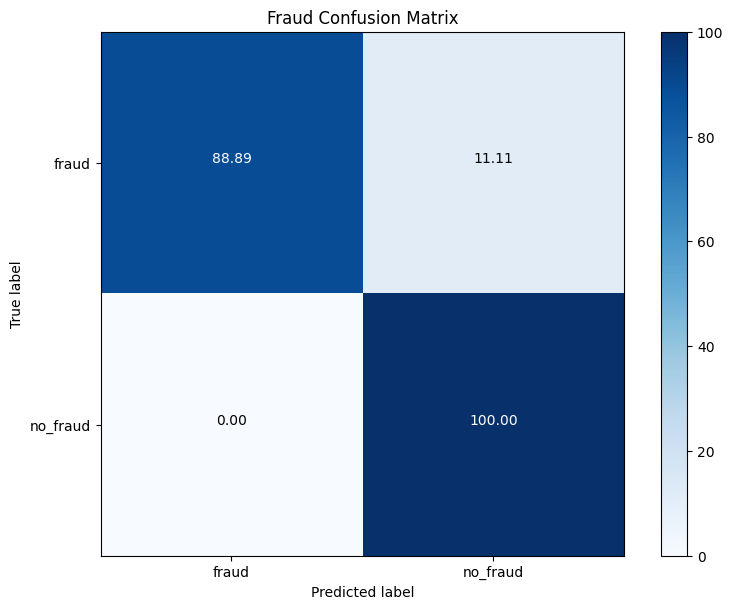

In [62]:
test_names = np.unique(names)
fraud_confusion_matrix = confusion_matrix(names, transaction_pred_fraud, labels =test_names)
title = 'Fraud Confusion Matrix'
cmap = plt.cm.Blues

plt.figure(figsize=(8, 6))
fraud_confusion_matrix = (
    fraud_confusion_matrix.astype('float') / fraud_confusion_matrix.sum(axis=1)[:, np.newaxis]
    ) * 100

plt.imshow(fraud_confusion_matrix, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(test_names))
plt.xticks(tick_marks, test_names)
plt.yticks(tick_marks, test_names)

fmt = '.2f'
thresh = fraud_confusion_matrix.max() / 2.
for i, j in itertools.product(range(fraud_confusion_matrix.shape[0]), range(fraud_confusion_matrix.shape[1])):
    plt.text(j, i, format(fraud_confusion_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if fraud_confusion_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

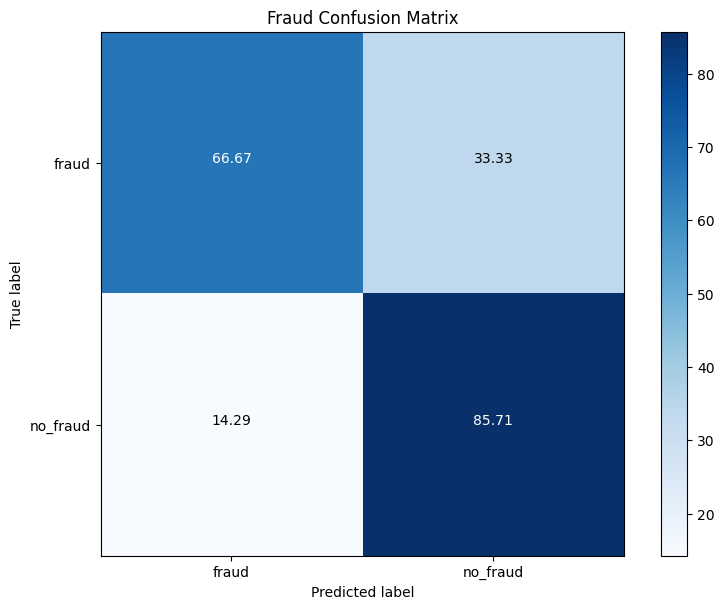

In [68]:
# Simulating a real data set collected to test to evaluate the model
test_data = {
        'fraud_status':  ['no_fraud', 'no_fraud', 'no_fraud', 'fraud','no_fraud', 'no_fraud', 'no_fraud', 'fraud', 'no_fraud', 'fraud'],
        'LocationTrack': [0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
        'airport':       [1, 0, 0, 1, 1, 0, 0, 1, 1, 1], 
        'Localcountry':  [1, 1, 1, 0, 1, 1, 1, 0, 0, 1],
        'LocalState':    [1, 1, 1, 0, 1, 1, 1, 0, 0, 1],
        'LocalCity':     [1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
       }
test_df = pd.DataFrame(test_data)

transaction_test_labels = test_df["fraud_status"]
transaction_test_scores = test_df[['LocationTrack','airport','Localcountry','LocalState','LocalCity']]

transaction_pred_fraud = transaction_tree.predict(transaction_test_scores)
                                                  
test_names = np.unique(transaction_test_labels)
fraud_confusion_matrix = confusion_matrix(transaction_test_labels, transaction_pred_fraud, labels =test_names)
title = 'Fraud Confusion Matrix'
cmap = plt.cm.Blues

plt.figure(figsize=(8, 6))
fraud_confusion_matrix = (
    fraud_confusion_matrix.astype('float') / fraud_confusion_matrix.sum(axis=1)[:, np.newaxis]
    ) * 100

plt.imshow(fraud_confusion_matrix, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(test_names))
plt.xticks(tick_marks, test_names)
plt.yticks(tick_marks, test_names)

fmt = '.2f'
thresh = fraud_confusion_matrix.max() / 2.
for i, j in itertools.product(range(fraud_confusion_matrix.shape[0]), range(fraud_confusion_matrix.shape[1])):
    plt.text(j, i, format(fraud_confusion_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if fraud_confusion_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

The predictive model results during the test case:
- Of all cases reported as fraud confirmed by the bank, 67% were correctly classified as fraud and 33% were incorrectly classified as non-fraud.
- All cases reported as No Fraud by the bank, 86% were correctly classified as non-fraud and 14% were incorrectly classified as fraud.

In my opinion, this predictive model will help reduce false positive fraud rejections and related customer complaints. We must work on fine-tuning the tool, adding more variables and test cases, and iterating several times in this evaluation process, focusing on obtaining a more accurate prediction.

## Author
#### Alain Linares